
Demonstrating coding for Mixed Sequence:
Input bits: [1, 0, 1, 0]


<ipython-input-6-346a01184afd>:101: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


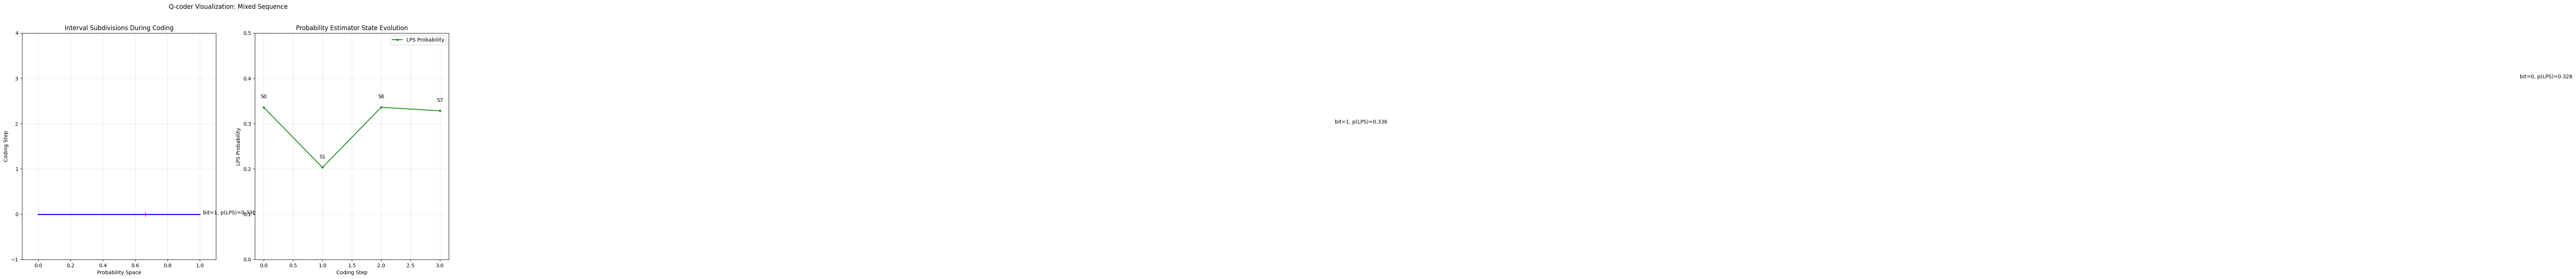


Observations:
- The left plot shows how the interval is progressively subdivided
- Blue lines show the current interval
- Red markers show the subdivision points
- The right plot shows how the probability estimates adapt

Demonstrating coding for Repeated MPS:
Input bits: [1, 1, 1, 1]


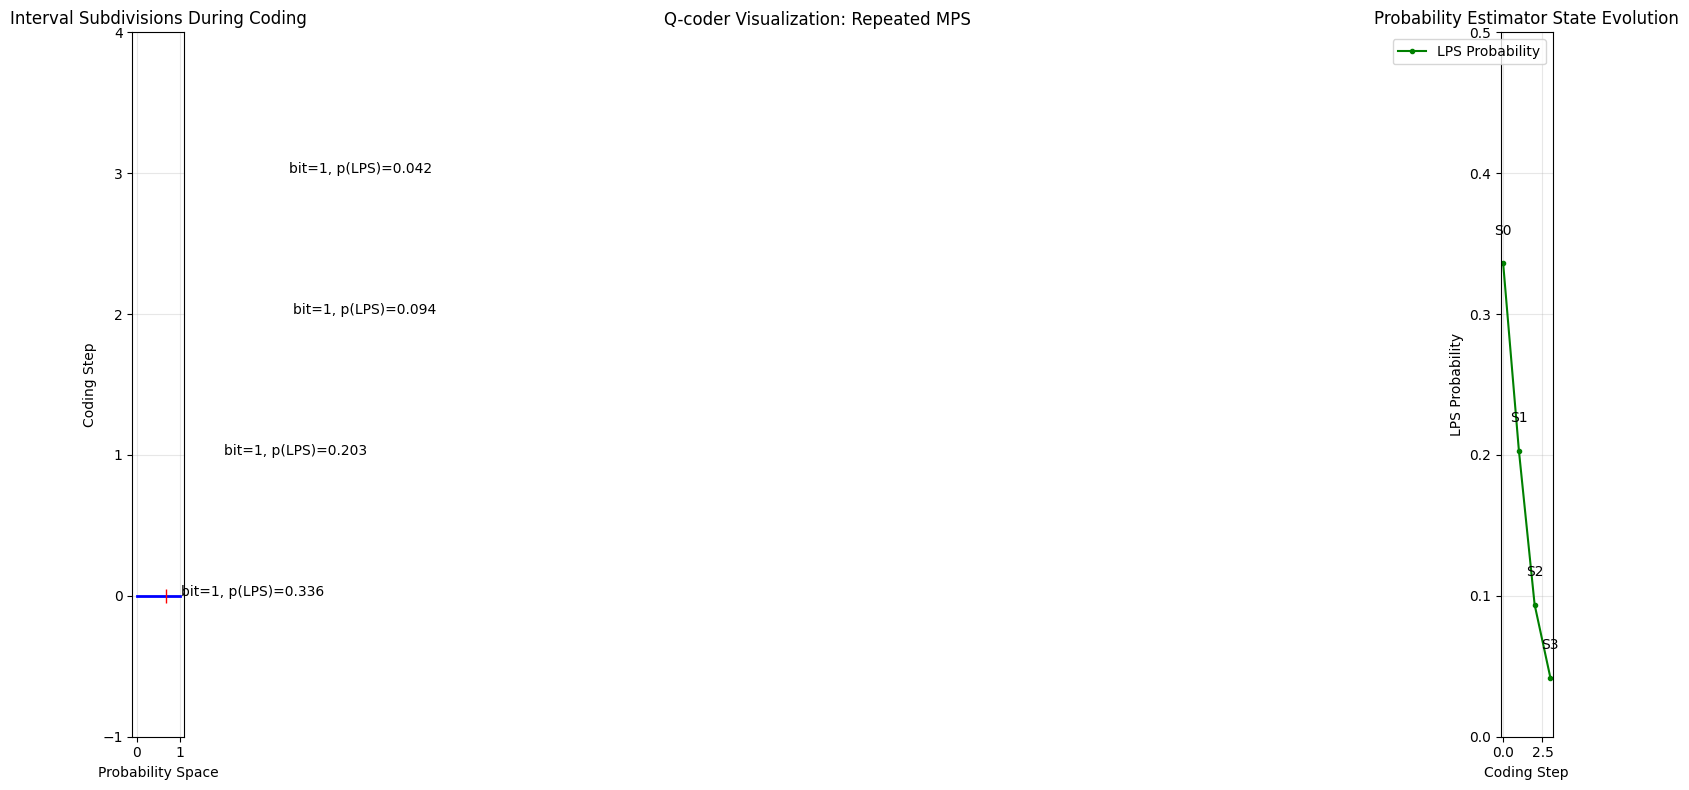


Observations:
- The left plot shows how the interval is progressively subdivided
- Blue lines show the current interval
- Red markers show the subdivision points
- The right plot shows how the probability estimates adapt

Demonstrating coding for Alternating Pattern:
Input bits: [0, 0, 1, 1]


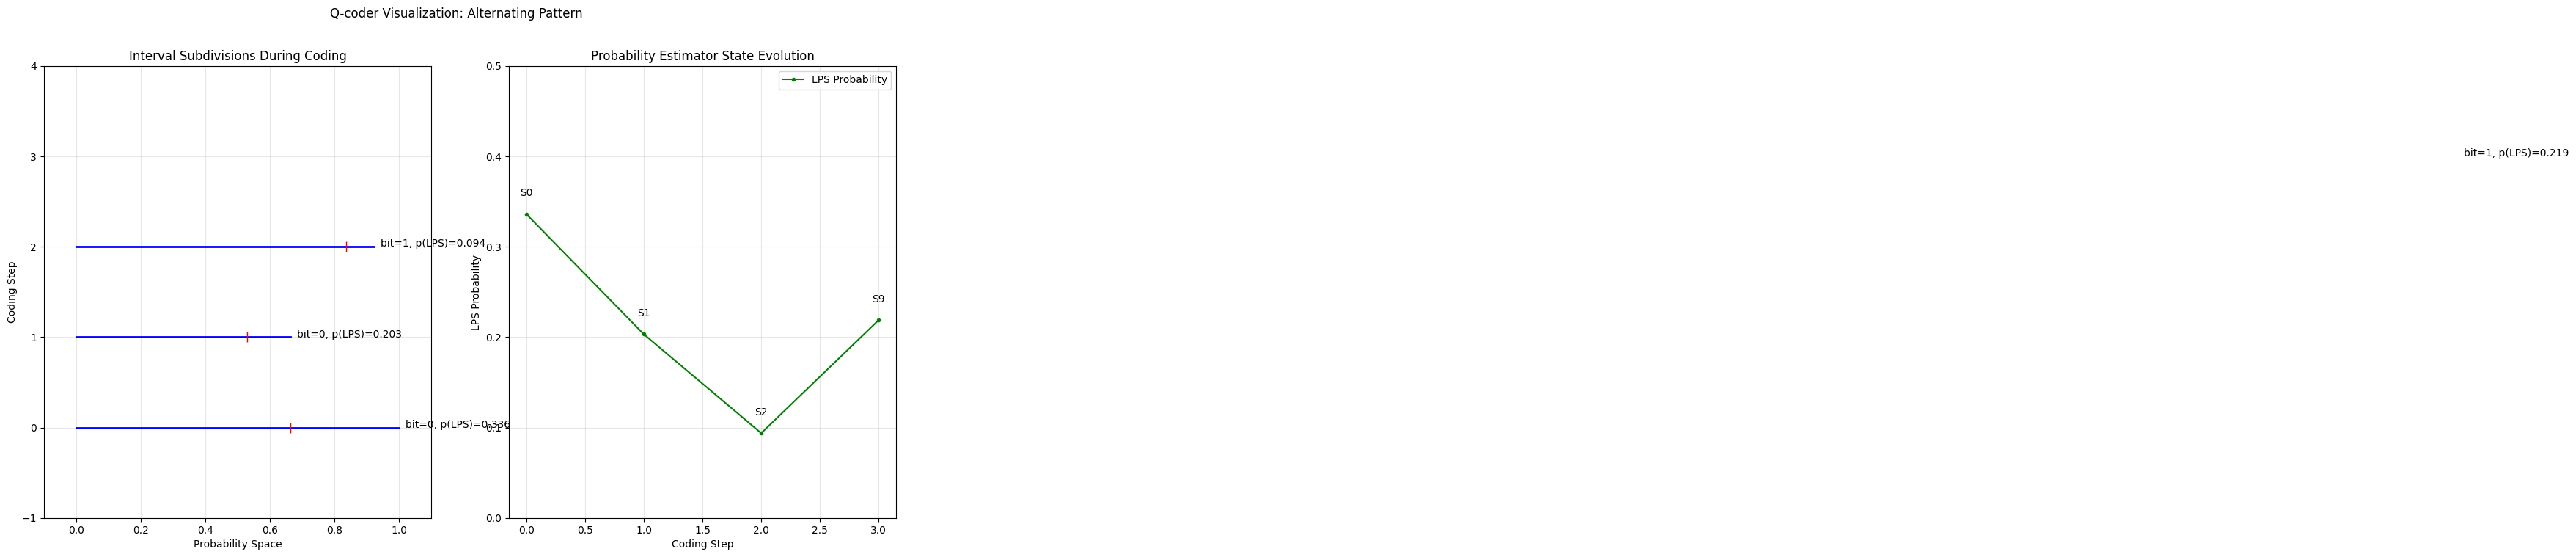


Observations:
- The left plot shows how the interval is progressively subdivided
- Blue lines show the current interval
- Red markers show the subdivision points
- The right plot shows how the probability estimates adapt


In [6]:
import numpy as np
import matplotlib.pyplot as plt

class VisualQCoder:
    def __init__(self):
        self.A = 0x10000  # Interval size (Q16 format)
        self.C = 0        # Code register
        self.intervals = []  # Store interval history
        self.pe = ProbabilityEstimator()

    def encode_bit(self, bit):
        """Encode a bit and store visualization data."""
        # Get current interval bounds
        low = self.C / 0x10000
        high = (self.C + self.A) / 0x10000

        # Get probability estimate
        Qe = int(self.pe.get_probability() * 0x10000)
        prob_lps = Qe / 0x10000

        # Calculate subdivision point
        mid = low + (high - low) * (1 - prob_lps)

        # Store interval information
        self.intervals.append({
            'bit': bit,
            'low': low,
            'high': high,
            'mid': mid,
            'prob_lps': prob_lps,
            'state': self.pe.current_state
        })

        # Perform normal Q-coder operations
        if bit == self.pe.mps:
            self.A -= Qe
        else:
            self.C += self.A - Qe
            self.A = Qe

        # Renormalization
        while self.A < 0x8000:
            self.A *= 2
            self.C *= 2

        self.pe.update(bit)

def visualize_coding_process(bits):
    """Create a detailed visualization of the coding process."""
    coder = VisualQCoder()

    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))

    # Process each bit
    for bit in bits:
        coder.encode_bit(bit)

    # Plot interval subdivisions
    ax1.set_title('Interval Subdivisions During Coding')
    ax1.set_xlabel('Probability Space')
    ax1.set_ylabel('Coding Step')

    # Draw intervals
    for i, interval in enumerate(coder.intervals):
        # Draw full interval
        ax1.plot([interval['low'], interval['high']], [i, i], 'b-', linewidth=2)

        # Draw subdivision point
        ax1.plot([interval['mid']], [i], 'r|', markersize=10)

        # Add bit and probability information
        ax1.text(interval['high'] + 0.02, i,
                f"bit={interval['bit']}, p(LPS)={interval['prob_lps']:.3f}")

    ax1.set_ylim(-1, len(bits))
    ax1.set_xlim(-0.1, 1.1)
    ax1.grid(True, alpha=0.3)

    # Plot probability evolution
    ax2.set_title('Probability Estimator State Evolution')
    ax2.set_xlabel('Coding Step')
    ax2.set_ylabel('LPS Probability')

    steps = range(len(coder.intervals))
    probs = [interval['prob_lps'] for interval in coder.intervals]
    states = [interval['state'] for interval in coder.intervals]

    # Plot probability changes
    ax2.plot(steps, probs, 'g.-', label='LPS Probability')
    ax2.grid(True, alpha=0.3)

    # Add state numbers
    for i, state in enumerate(states):
        ax2.text(i, probs[i] + 0.02, f'S{state}',
                horizontalalignment='center')

    ax2.set_ylim(0, 0.5)
    ax2.legend()

    plt.tight_layout()
    return fig

class ProbabilityEstimator:
    """
    Implements a complete probability estimation state machine for Q/MQ coding.
    Each state entry contains:
    - Qe: Probability estimate (scaled by 2^16)
    - NMPS: Next state if MPS occurs
    - NLPS: Next state if LPS occurs
    - switch: Whether to switch MPS symbol in LPS transition
    """
    def __init__(self):
        # Complete state table based on JBIG specification
        self.state_table = {
            0: (0x5601, 1, 1, 1),     # Initial state
            1: (0x3401, 2, 6, 0),
            2: (0x1801, 3, 9, 0),
            3: (0x0AC1, 4, 12, 0),
            4: (0x0521, 5, 29, 0),
            5: (0x0221, 38, 33, 0),
            6: (0x5601, 7, 6, 1),
            7: (0x5401, 8, 14, 0),
            8: (0x4801, 9, 14, 0),
            9: (0x3801, 10, 14, 0),
            10: (0x3001, 11, 17, 0),
            11: (0x2401, 12, 18, 0),
            12: (0x1C01, 13, 20, 0),
            13: (0x1601, 29, 21, 0),
            14: (0x5601, 15, 14, 1),
            15: (0x5401, 16, 14, 0),
            16: (0x5101, 17, 15, 0),
            17: (0x4801, 18, 16, 0),
            18: (0x3801, 19, 17, 0),
            19: (0x3401, 20, 18, 0),
            20: (0x3001, 21, 19, 0),
            21: (0x2801, 22, 19, 0),
            22: (0x2401, 23, 20, 0),
            23: (0x2201, 24, 21, 0),
            24: (0x1C01, 25, 22, 0),
            25: (0x1801, 26, 23, 0),
            26: (0x1601, 27, 24, 0),
            27: (0x1401, 28, 25, 0),
            28: (0x1201, 29, 26, 0),
            29: (0x1101, 30, 27, 0),
            30: (0x0AC1, 31, 28, 0),
            31: (0x09C1, 32, 29, 0),
            32: (0x08A1, 33, 30, 0),
            33: (0x0521, 34, 31, 0),
            34: (0x0441, 35, 32, 0),
            35: (0x02A1, 36, 33, 0),
            36: (0x0221, 37, 34, 0),
            37: (0x0141, 38, 35, 0),
            38: (0x0111, 39, 36, 0),
            39: (0x0085, 40, 37, 0),
            40: (0x0049, 41, 38, 0),
            41: (0x0025, 42, 39, 0),
            42: (0x0015, 43, 40, 0),
            43: (0x0009, 44, 41, 0),
            44: (0x0005, 45, 42, 0),
            45: (0x0001, 45, 43, 0),
        }
        self.current_state = 0
        self.mps = 0

    def get_probability(self):
        """Get the current probability estimate for LPS."""
        return self.state_table[self.current_state][0] / 65536.0

    def update(self, bit):
        """Update the probability estimate based on the received bit."""
        Qe, NMPS, NLPS, switch = self.state_table[self.current_state]

        if bit == self.mps:
            self.current_state = NMPS
        else:
            if switch:
                self.mps = 1 - self.mps
            self.current_state = NLPS

class QCoder:
    """
    A more complete implementation of Q-coder principles.
    """
    def __init__(self):
        self.A = 0x10000  # Interval size (Q16 format)
        self.C = 0        # Code register
        self.CT = 11      # Bit counter
        self.buffer = []  # Output buffer
        self.pe = ProbabilityEstimator()
        self.byte_buffer = 0
        self.bits_to_follow = 0

    def encode_bit(self, bit):
        """Encode a single bit using Q-coder principles."""
        # Get probability estimate
        Qe = int(self.pe.get_probability() * 0x10000)

        # Print internal state for debugging
        print(f"Current state: {self.pe.current_state}")
        print(f"Qe: {Qe:04x}, A: {self.A:04x}, C: {self.C:04x}")

        # Interval subdivision
        if bit == self.pe.mps:
            self.A -= Qe
        else:
            self.C += self.A - Qe
            self.A = Qe

        # Renormalization loop
        while self.A < 0x8000:
            if self.C >= 0x8000:
                self.output_bit(1)
            else:
                self.output_bit(0)
            self.A *= 2
            self.C *= 2
            self.CT -= 1

            if self.CT == 0:
                self.flush_byte()

        # Update probability estimate
        self.pe.update(bit)

    def output_bit(self, bit):
        """Output a bit, handling carry propagation."""
        self.byte_buffer = (self.byte_buffer << 1) | bit
        self.buffer.append(bit)

        if len(self.buffer) >= 8:
            self.flush_byte()

    def flush_byte(self):
        """Flush current byte to output."""
        if len(self.buffer) > 0:
            byte = 0
            for i in range(min(8, len(self.buffer))):
                byte = (byte << 1) | self.buffer[i]
            self.buffer = self.buffer[8:]
            self.CT = 8

def demonstrate_with_visualization():
    """Demonstrate Q-coder operation with visualizations."""
    # Test sequences to show different patterns
    test_sequences = [
        ([1, 0, 1, 0], "Mixed Sequence"),
        ([1, 1, 1, 1], "Repeated MPS"),
        ([0, 0, 1, 1], "Alternating Pattern")
    ]

    for bits, title in test_sequences:
        print(f"\nDemonstrating coding for {title}:")
        print(f"Input bits: {bits}")

        # Create and show visualization
        fig = visualize_coding_process(bits)
        plt.suptitle(f"Q-coder Visualization: {title}")
        plt.show()

        print("\nObservations:")
        print("- The left plot shows how the interval is progressively subdivided")
        print("- Blue lines show the current interval")
        print("- Red markers show the subdivision points")
        print("- The right plot shows how the probability estimates adapt")

# Run demonstration
demonstrate_with_visualization()